In [ ]:
!pip -q install -U keras-tuner gputil

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 11.2 MB/s eta 0:00:00


In [ ]:
import os
import time
import json
import platform
import numpy as np
import GPUtil
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import os, math, time, json, platform, timeit


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Paths
BASE_PATH = "/content/drive/MyDrive/EdgeMeter_AIv2/data"
LOG_PATH = os.path.join(BASE_PATH, "lstm_training_log_48_12.json")

# Loading Data
X_train = np.load(os.path.join(BASE_PATH, "X_train_48_12.npy"))
y_train = np.load(os.path.join(BASE_PATH, "y_train_48_12.npy"))
X_val   = np.load(os.path.join(BASE_PATH, "X_val_48_12.npy"))
y_val   = np.load(os.path.join(BASE_PATH, "y_val_48_12.npy"))
X_test  = np.load(os.path.join(BASE_PATH, "X_test_48_12.npy"))
y_test  = np.load(os.path.join(BASE_PATH, "y_test_48_12.npy"))

input_shape = X_train.shape[1:]


In [ ]:
# Loading Best Hyperparameters
with open(os.path.join(BASE_PATH, "lstm_tuning_log_48to12.json")) as f:
    best_hp = json.load(f)

best_hps = best_hp["best_hyperparameters"]
print("Best HPs:", best_hps)


Best HPs: {'units': 128, 'dropout': 0.1, 'learning_rate': 0.0001}


In [ ]:
# Build Model
model = keras.Sequential([
    layers.Input(shape=input_shape),
    layers.LSTM(best_hps["units"]),
    layers.Dropout(best_hps["dropout"]),
    layers.Dense(12)
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=best_hps["learning_rate"]),
    loss="mse",
    metrics=["mae"]
)

# Callbacks
early_stop = callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, verbose=1)


In [ ]:
# Train
start_time = time.time()
with tf.device("/GPU:0"):
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=512,
        callbacks=[early_stop, reduce_lr],
        verbose=1
    )
end_time = time.time()

Epoch 1/50
20938/20938 ━━━━━━━━━━━━━━━━━━━━ 152s 7ms/step - loss: 0.0641 - mae: 0.1399 - val_loss: 0.0450 - val_mae: 0.1199 - learning_rate: 1.0000e-04
Epoch 2/50
20938/20938 ━━━━━━━━━━━━━━━━━━━━ 139s 7ms/step - loss: 0.0451 - mae: 0.1102 - val_loss: 0.0427 - val_mae: 0.1084 - learning_rate: 1.0000e-04
Epoch 3/50
20938/20938 ━━━━━━━━━━━━━━━━━━━━ 139s 7ms/step - loss: 0.0431 - mae: 0.1072 - val_loss: 0.0422 - val_mae: 0.1059 - learning_rate: 1.0000e-04
Epoch 4/50
20938/20938 ━━━━━━━━━━━━━━━━━━━━ 140s 7ms/step - loss: 0.0422 - mae: 0.1059 - val_loss: 0.0416 - val_mae: 0.1078 - learning_rate: 1.0000e-04
Epoch 5/50
20938/20938 ━━━━━━━━━━━━━━━━━━━━ 139s 7ms/step - loss: 0.0416 - mae: 0.1050 - val_loss: 0.0414 - val_mae: 0.1089 - learning_rate: 1.0000e-04
Epoch 6/50
20938/20938 ━━━━━━━━━━━━━━━━━━━━ 139s 7ms/step - loss: 0.0412 - mae: 0.1044 - val_loss: 0.0413 - val_mae: 0.1071 - learning_rate: 1.0000e-04
Epoch 7/50
20938/20938 ━━━━━━━━━━━━━━━━━━━━ 139s 7ms/step - loss: 0.0410 - mae: 0.1040 -

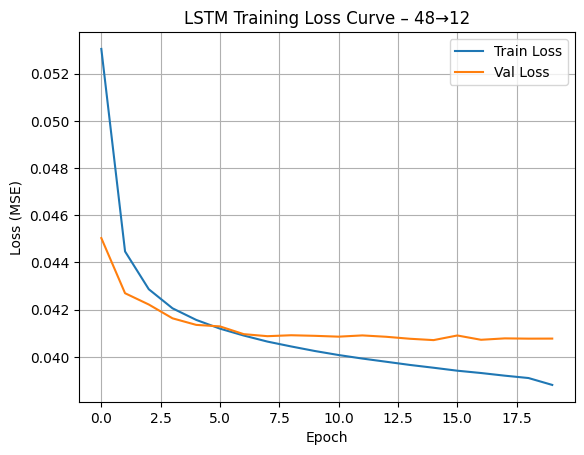

In [ ]:
# Saving Training History
hist_df = pd.DataFrame(history.history)
hist_df.to_csv(os.path.join(BASE_PATH, "LSTM_Training_History_48_12.csv"))

# Training Curve
plt.figure()
plt.plot(hist_df["loss"], label="Train Loss")
plt.plot(hist_df["val_loss"], label="Val Loss")
plt.title("LSTM Training Loss Curve – 48→12")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(BASE_PATH, "LSTM_Training_Curve_48_12.png"))
plt.show()

In [ ]:
import gc

# Saving GPU-trained weights
WEIGHTS_PATH = os.path.join(BASE_PATH, "lstm_48_12_trained.weights.h5")
model.save_weights(WEIGHTS_PATH)
print(f" Saved GPU-trained weights to {WEIGHTS_PATH}")


 Saved GPU-trained weights to /content/drive/MyDrive/EdgeMeter_AIv2/data/lstm_48_12_trained.weights.h5


In [ ]:
# Evaluation
y_pred = model.predict(X_test, batch_size=1024, verbose=0)
test_mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(mse)
test_r2 = r2_score(y_test, y_pred)


In [ ]:
SAVE_DIR   = os.path.join(BASE_PATH, "Final_LSTM_Model_48_12")      # SavedModel folder
SAVE_H5    = os.path.join(BASE_PATH, "Final_LSTM_Model_48_12.h5")   # HDF5 file
SAVE_KERAS = os.path.join(BASE_PATH, "Final_LSTM_Model_48_12.keras")# Native Keras file

model.export(SAVE_DIR)

model.save(SAVE_H5)

model.save(SAVE_KERAS)


Saved artifact at '/content/drive/MyDrive/EdgeMeter_AIv2/data/Final_LSTM_Model_48_12'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 48, 11), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 12), dtype=tf.float32, name=None)
Captures:
  135074239774544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135074239773776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135074240004560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135074239774352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135074240006480: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [ ]:
# Model Size
def get_dir_size_mb(path):
    total_size = 0
    for dirpath, _, filenames in os.walk(path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            if os.path.isfile(fp):
                total_size += os.path.getsize(fp)
    return total_size / 1e6

size_savedmodel_mb = get_dir_size_mb(SAVE_DIR)
size_h5_mb = os.path.getsize(SAVE_H5) / 1e6 if os.path.exists(SAVE_H5) else None
size_keras_mb = os.path.getsize(SAVE_KERAS) / 1e6 if os.path.exists(SAVE_KERAS) else None


   usage_bin       MAE      RMSE        R2
0          0  0.043204  0.095391  0.231797
1          1  0.065634  0.125819  0.233987
2          2  0.084809  0.156658  0.297827
3          3  0.127129  0.233788  0.313425
4          4  0.211417  0.365071  0.703220


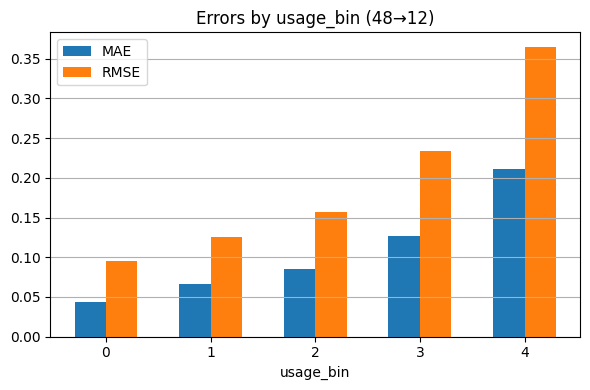

In [ ]:
# Error by usage bin
import numpy as np, pandas as pd, os
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

USAGE_BIN_IDX = 10

bins = X_test[:, -1, USAGE_BIN_IDX].astype(int)
rows = []
for b in np.sort(np.unique(bins)):
    mask = (bins == b)
    yt = y_test[mask]
    yp = y_pred[mask]
    if yt.size == 0:
        continue
    mae  = mean_absolute_error(yt, yp)
    rmse = np.sqrt(mean_squared_error(yt, yp))
    r2   = r2_score(yt, yp)
    rows.append({'usage_bin': int(b), 'MAE': mae, 'RMSE': rmse, 'R2': r2})

by_bin = pd.DataFrame(rows).sort_values('usage_bin')
by_bin_csv = os.path.join(BASE_PATH, "LSTM_metrics_by_usage_bin_48_12.csv")
by_bin.to_csv(by_bin_csv, index=False)
print(by_bin)

# Plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(6,4))
ax.bar(by_bin['usage_bin']-0.15, by_bin['MAE'], width=0.3, label='MAE')
ax.bar(by_bin['usage_bin']+0.15, by_bin['RMSE'], width=0.3, label='RMSE')
ax.set_xlabel('usage_bin'); ax.set_title('Errors by usage_bin (48→12)')
ax.grid(True, axis='y'); ax.legend()
fig.tight_layout()
fig.savefig(os.path.join(BASE_PATH, "LSTM_errors_by_usage_bin_48_12.png"))
plt.show(fig)



In [ ]:
# Residual diagnostics by hour‑of‑day
import numpy as np, pandas as pd, os

HOUR_IDX = 5  # ["...","hour","day_of_week",...]
hours = np.rint(X_test[:, -1, HOUR_IDX] * 23).astype(int).clip(0,23)
resid = (y_test - y_pred).reshape(len(y_test), 12)  # (N,12)
abs_resid = np.abs(resid).mean(axis=1)  # average across horizon

df_hr = pd.DataFrame({'hour': hours, 'abs_resid': abs_resid})
by_hr = df_hr.groupby('hour', as_index=False)['abs_resid'].mean()

by_hr_csv = os.path.join(BASE_PATH, "LSTM_abs_residual_by_hour_48_12.csv")
by_hr.to_csv(by_hr_csv, index=False)
print(by_hr.head())


   hour  abs_resid
0     0   0.059414
1    23   0.107498


In [ ]:
# Inference Time
sample_input = tf.convert_to_tensor(X_test[:1])
t0 = timeit.default_timer(); _ = model(sample_input); t1 = timeit.default_timer()
inference_time = (t1 - t0) * 1000.0

In [ ]:
# Log Final Metrics
gpus = GPUtil.getGPUs()
log_data = {
    "model_name": "LSTM_Final_48_12",
    "task": "Smart Meter Energy Forecasting",
    "tuning_type": "BayesianOptimization",
    "test_mae": float(test_mae),
    "test_rmse": float(test_rmse),
    "test_r2": float(test_r2),
    "params": int(model.count_params()),
    "model_size_mb_savedmodel": float(size_savedmodel_mb),
    "model_size_mb_h5": float(size_h5_mb) if size_h5_mb is not None else None,
    "model_size_mb_keras": float(size_keras_mb) if size_keras_mb is not None else None,
    "inference_time_ms": float(inference_time),
    "training_time_minutes": round((end_time - start_time) / 60, 2),
    "input_shape": list(map(int, X_train.shape[1:])),
    "units": best_hps["units"],
    "dropout": best_hps["dropout"],
    "learning_rate": best_hps["learning_rate"],
    "system_info": {
        "platform": platform.system(),
        "platform_version": platform.version(),
        "processor": platform.processor(),
        "gpu_used": GPUtil.getGPUs()[0].name if GPUtil.getGPUs() else "None"
    }
}

with open(os.path.join(BASE_PATH, "LSTM_Final_Log_48_12.json"), "w") as f:
    json.dump(log_data, f, indent=4)

In [ ]:
# Saving Predictions
np.savetxt(os.path.join(BASE_PATH, "LSTM_y_pred_48_12.csv"), y_pred, delimiter=",")

In [ ]:
import gc

# Converting model to TFLite version for edge
tf.keras.backend.clear_session()
gc.collect()
try:
    tf.config.experimental.set_visible_devices([], 'GPU')
    print(" GPU hidden for CPU rebuild.")
except Exception as e:
    print("⚠ Could not hide GPU:", e)

with tf.device("/CPU:0"):
    cpu_model = keras.Sequential([
        layers.Input(shape=input_shape),
        layers.LSTM(
            best_hps["units"],
            activation="tanh",
            recurrent_activation="sigmoid",
            recurrent_dropout=0.1,   # >0 forces pure TF kernel
            implementation=2
        ),
        layers.Dropout(best_hps["dropout"]),
        layers.Dense(12)
    ])
    cpu_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=best_hps["learning_rate"]),
        loss="mse",
        metrics=["mae"]
    )
    cpu_model.load_weights(WEIGHTS_PATH)

# Exporting SavedModel (CPU version, no cuDNN ops)
SAVE_DIR_CPU = os.path.join(BASE_PATH, "Final_LSTM_Model_48_12_CPU_clean")
cpu_model.export(SAVE_DIR_CPU)
print(" CPU-only SavedModel at:", SAVE_DIR_CPU)
converter = tf.lite.TFLiteConverter.from_saved_model(SAVE_DIR_CPU)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]
try:
    tflite_model = converter.convert()
except Exception as e:
    print("Builtins-only failed, retrying with SELECT_TF_OPS. Error:", e)
    converter.target_spec.supported_ops = [
        tf.lite.OpsSet.TFLITE_BUILTINS,
        tf.lite.OpsSet.SELECT_TF_OPS
    ]
    tflite_model = converter.convert()

# Saving TFLite file
TFLITE_PATH = os.path.join(BASE_PATH, "Final_LSTM_Model_48_12.tflite")
with open(TFLITE_PATH, "wb") as f:
    f.write(tflite_model)
print(f" TFLite model saved at: {TFLITE_PATH}")


✅ Saved GPU-trained weights to /content/drive/MyDrive/EdgeMeter_AIv2/data/lstm_48_12_trained.weights.h5
⚠ Could not hide GPU: Visible devices cannot be modified after being initialized


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Saved artifact at '/content/drive/MyDrive/EdgeMeter_AIv2/data/Final_LSTM_Model_48_12_CPU_clean'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 48, 11), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 12), dtype=tf.float32, name=None)
Captures:
  135074240012240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135074240012432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135074240013392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135074240012624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135074240011856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135074240008400: TensorSpec(shape=(), dtype=tf.resource, name=None)
✅ CPU-only SavedModel at: /content/drive/MyDrive/EdgeMeter_AIv2/data/Final_LSTM_Model_48_12_CPU_clean
Builtins-only failed, retrying with SELECT_TF_OPS. Error: <unknown>:0: error: loc(callsite(callsite(fused["TensorListReserve:", "sequential

In [ ]:
# Quick TFLite Sanity Check
interpreter = tf.lite.Interpreter(model_path=TFLITE_PATH)
interpreter.allocate_tensors()

inp = interpreter.get_input_details()[0]
out = interpreter.get_output_details()[0]

# Test with one real sample
sample = X_test[:1].astype(np.float32)
interpreter.set_tensor(inp["index"], sample)
interpreter.invoke()

pred = interpreter.get_tensor(out["index"])
print(" TFLite inference OK | Output shape:", pred.shape)
print("First prediction row:", pred[0])


✅ TFLite inference OK | Output shape: (1, 12)
First prediction row: [0.14843766 0.13303447 0.11576391 0.09934576 0.09772068 0.09143473
 0.07898504 0.08587922 0.07825647 0.07766231 0.07506762 0.1085154 ]


/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)
